In [1]:
from __future__ import division

from faculty_hiring.misc.plotting import *  # Definitions for LABEL_SIZE and such
from faculty_hiring.misc.gaussian_kde import gaussian_kde
from faculty_hiring.parse import faculty_parser, institution_parser
from faculty_hiring.parse import load
from faculty_hiring.parse.nces import parse_phds_awarded
from faculty_hiring.misc.subfield import topic_descriptions, num_topics 
# topic_descriptions is a list of topic descriptions, num_topics is the length of that list.

from scipy.stats.stats import pearsonr, mannwhitneyu
from collections import Counter
import statsmodels.api as sm
import numpy as np
import scipy as sp
import os
from matplotlib.lines import Line2D

# File locations
faculty_file = '/Users/samway/Documents/Work/ClausetLab/projects/faculty_hiring/data/faculty_cs_CURRENT.txt'
inst_file = '/Users/samway/Documents/Work/ClausetLab/projects/faculty_hiring/data/inst_cs.txt'
figures_dir = '/Users/samway/Documents/Work/ClausetLab/projects/faculty_hiring/notebooks/figures/'
nces_table = '/Users/samway/Documents/Work/ClausetLab/projects/faculty_hiring/data/nces_table.txt'

# (Optional, these are for loading publication profiles)
# dblp_dir = '/Users/samway/Documents/Work/ClausetLab/projects/faculty_hiring/data/profiles_DBLP_all/'
# gs_dir = '/Users/samway/Documents/Work/ClausetLab/projects/faculty_hiring/data/profiles_GS_all/'

## Loading the dataset

In [2]:
inst = institution_parser.parse_institution_records(open(inst_file))
faculty = load.load_assistant_profs(open(faculty_file), inst)
# load.load_all_publications(faculty, dblp_dir, gs_dir) # <-- need to have gs_dir and dblp_dir defined
nces_years, nces_women, nces_total = parse_phds_awarded(nces_table)

discarded = [f for f in faculty_parser.parse_faculty_records(open(faculty_file,'rU')) 
             if (f.first_asst_job_year is not None and 
                 f.first_asst_job_year >= 1970 and
                 f.first_asst_job_year < 2012 and
                 f.phd_location is not None and 
                 (f.phd_location not in inst or f.first_asst_job_location not in inst))]

all_faculty = [f for f in faculty_parser.parse_faculty_records(open(faculty_file,'rU'))]

In [3]:
count = 0.
total = 0.
for person in all_faculty:
    if person.current in ['Associate Professor', 'Assistant Professor']:
        total += 1.
        if person.is_female:
            count += 1.
        
print count / total

0.177566539924


In [4]:
count = 0.

for person in faculty:
    if person.first_asst_job_year in [1980, 1992, 1997, 2002, 2009]:
        count += 1
        
print count / len(faculty)

0.1420828494


##### Wait, what are those things?

They're dictionaries. Here's the entry for Stanford:

In [21]:
inst['Stanford University']

{'NRC95': 1,
 'Region': 'West',
 'USN2010': 1,
 'pi': 2.23,
 'pi_inv': 0.4484304932735426,
 'pi_rescaled': 1.0,
 'u': 1}

For institutions that aren't in our records, there's an 'UNKNOWN' entry. Assume that if we haven't heard of the institution that the hiring committees haven't either. Here's code to grab the institution profile for a person, which, if it doesn't exists grabs the 'UNKNOWN' profile:

In [22]:
inst.get('Weird University', inst['UNKNOWN'])

{'Region': 'Earth',
 'pi': 206.0,
 'pi_inv': 0.0048543689320388345,
 'pi_rescaled': 0.0048543689320388328}

What about the faculty records?

In [23]:
# These will do the same thing:
f = faculty[0]
print f['facultyName']
print f.facultyName

Gail-Joon Ahn
Gail-Joon Ahn


In [24]:
# These are often important 
print f.first_asst_job_location, f.first_asst_job_year
print f.phd_location, f.phd_year

University of North Carolina, Charlotte 2000
George Mason University 2000


## Basic Stats

In [25]:
''' Fraction of women '''
print len(faculty)
print np.sum([f.is_female for f in faculty])
print float(np.sum([f.is_female for f in faculty])) / len(faculty)

2583
418
0.161827332559


In [26]:
''' Fraction of placements within the same geographical region '''
c = 0
for person in faculty:
    if person.first_asst_job_region == person.phd_region:
        c += 1.
print c / len(faculty)

0.405729771583


In [27]:
''' How many people have publication profiles '''
c = 0
for person in faculty:
    if 'dblp' in person:
        c += 1.
        
print c, c / len(faculty)

2453.0 0.949670925281


In [28]:
''' How many people have publication profiles '''
b = 0.
a = 0.
for person in faculty:
    if not person.is_female:
        if person.first_asst_job_year > 2002:
            a += 1
        else:
            b += 1
        
print a/(a+b)

0.328406466513


In [29]:
''' Average z-scores ''' 
zscores_m_up = []
zscores_w_up = []
zscores_m_down = []
zscores_w_down = []

for person in faculty:
    female = person.is_female
    up = person.first_asst_job_rank > person.phd_rank
    down = person.first_asst_job_rank < person.phd_rank
    
    if not female and up:
        zscores_m_up.append(person.dblp_z)
    elif not female and down:
        zscores_m_down.append(person.dblp_z)
    elif female and up:
        zscores_w_up.append(person.dblp_z)
    elif female and down:
        zscores_w_down.append(person.dblp_z)
        
print 'Men, up: \t', np.median(zscores_m_up)
print 'Men, down: \t', np.median(zscores_m_down)
print ''
print 'Women, up: \t', np.median(zscores_w_up)
print 'Women, down: \t', np.median(zscores_w_down)

AttributeError: faculty_record instance has no attribute 'dblp_z'

In [ ]:
stat, pval = mannwhitneyu(zscores_m_up, zscores_w_up)
sig = pval < 0.05    
print sig, pval

In [ ]:
''' Median z-scores ''' 
men = []
women = []

for person in faculty:
    if True:
        if person.is_female:
            women.append(person.dblp_z)
        else:
            men.append(person.dblp_z)

stat, pval = mannwhitneyu(men, women)
sig = pval < 0.05    
print sig, pval

print 'Men:   ', np.median(men)
print 'Women: ', np.median(women)

In [ ]:
''' Since year X ''' 
men = 0.
women = 0.

for person in faculty:
    if person.first_asst_job_year < 2002:
        if person.is_female:
            women += 1
        else:
            men += 1

print women/(men+women)

## Plotting example

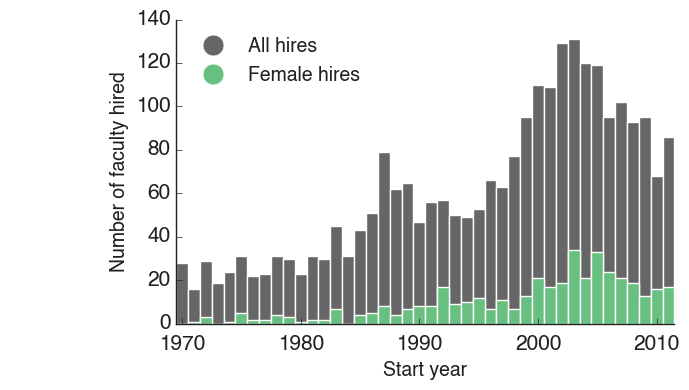

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

start_years = np.zeros(len(faculty), dtype=int)
female_start_years = []

for i, f in enumerate(faculty):
    start_years[i] = f.first_asst_job_year
    if f.sex == 'F':
        female_start_years.append(f.first_asst_job_year)
        
bins = np.arange(1955, 2012) + 0.5

temp = FEMALE_COLOR
FEMALE_COLOR = (0.40254901960784313, 0.75274509803921569, 0.50254901960784313)
    
# I have a lot of pre-defined font sizes and stuff that are in faculty_hiring.misc.plotting
# Try to use these wherever possible to help keep things consistent. 
x_pad = 0.5
ax.set_xlim(1970-x_pad, 2012-x_pad)
ax.hist(start_years, bins=bins, color=DARK_COLOR, edgecolor='w', clip_on=False, label='All hires')
ax.hist(female_start_years, bins=bins, color=FEMALE_COLOR, edgecolor='w', clip_on=False, label='Female hires')
ax.set_xlabel('Start year', fontsize=LABEL_SIZE)
ax.set_ylabel('Number of faculty hired', fontsize=LABEL_SIZE)
ax.tick_params(axis='both', which='major', labelsize=TICK_SIZE)
hide_right_top_axis(ax)

fake_line_all = Line2D(range(1), range(1), color=DARK_COLOR, marker='o',markersize=15, linestyle='None', markeredgecolor='w')
fake_line_f = Line2D(range(1), range(1), color=FEMALE_COLOR, marker='o',markersize=15, linestyle='None', markeredgecolor='w')
plt.legend((fake_line_all,fake_line_f),('All hires','Female hires'), numpoints=1, loc='upper left', frameon=False, fontsize=LABEL_SIZE)
#ax.legend(loc='upper left', frameon=False)
plt.savefig(os.path.join(figures_dir, 'faculty_per_year.pdf'))

FEMALE_COLOR = temp

plt.show()

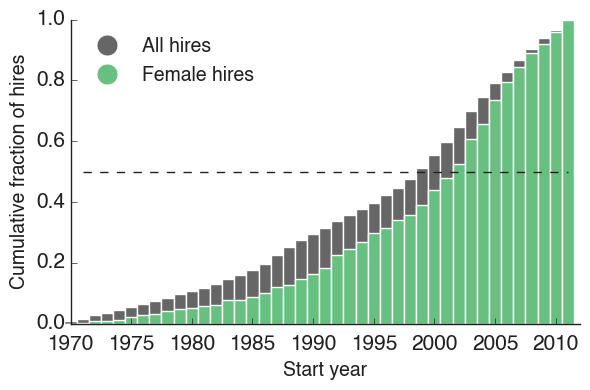

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

start_years = np.zeros(len(faculty), dtype=int)
female_start_years = []

for i, f in enumerate(faculty):
    start_years[i] = f.first_asst_job_year
    if f.sex == 'F':
        female_start_years.append(f.first_asst_job_year)
        
bin_offset = 0.5
bins = np.arange(1969, 2012) + bin_offset
year_range = np.arange(1970, 2012)
    
# I have a lot of pre-defined font sizes and stuff that are in faculty_hiring.misc.plotting
# Try to use these wherever possible to help keep things consistent. 
ax.set_xlim(1970, 2012)
start_years_hist,_ = np.histogram(start_years, bins=bins)
start_years_hist_women,_ = np.histogram(female_start_years, bins=bins)

cumulative_all = np.cumsum(start_years_hist)
cumulative_women = np.cumsum(start_years_hist_women)

ax.bar(year_range, cumulative_all / float(cumulative_all[-1]), color=DARK_COLOR, width=1, edgecolor='w', align='center', clip_on=False)
ax.bar(year_range, cumulative_women / float(cumulative_women[-1]), color=FEMALE_COLOR, width=1, edgecolor='w', align='center', clip_on=False)

ax.plot([1971,2011], [0.5, 0.5], '--', color=ALMOST_BLACK)

ax.set_xlabel('Start year', fontsize=LABEL_SIZE)
ax.set_ylabel('Cumulative fraction of hires', fontsize=LABEL_SIZE)
ax.tick_params(axis='both', which='major', labelsize=TICK_SIZE)
hide_right_top_axis(ax)
fake_line_all = Line2D(range(1), range(1), color=DARK_COLOR, marker='o',markersize=15, linestyle='None', markeredgecolor='w')
fake_line_f = Line2D(range(1), range(1), color=FEMALE_COLOR, marker='o',markersize=15, linestyle='None', markeredgecolor='w')
plt.legend((fake_line_all,fake_line_f),('All hires','Female hires'), numpoints=1, loc='upper left', frameon=False, fontsize=LABEL_SIZE)

plt.savefig(os.path.join(figures_dir, 'cumulative_fraction.pdf'))
plt.show()

In [33]:
print 'Correlation coefficient (Past 1990):'
keep = np.array([i for i, y in enumerate(year_range) if y in nces_years])
nces = np.cumsum(nces_women)/np.cumsum(nces_total)
#us = np.array(avg)[keep]
select = np.where(nces_years >= 1990)[0]

#print pearsonr(nces[select], us[select])[0]

Correlation coefficient (Past 1990):


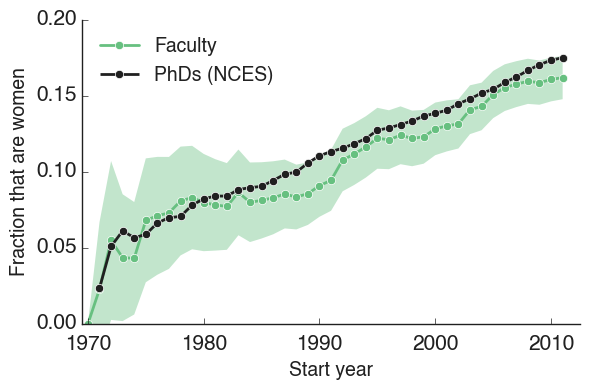

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

#http://www.nsf.gov/statistics/infbrief/nsf08308/

nsf_years = np.array([1985, 1987, 1989, 1991, 1993, 1995, 1997, 1999, 2001, 2003, 2006])
nsf_fracs = np.array([12.6, 13.1, 13.9, 15.2, 18.4, 17.2, 20.4, 22.2, 19.9, 17.7, 21.2]) / 100.

def mean_confidence(positives, total, confidence=0.95, iters=1000, z=1.96):
    upper = np.zeros_like(total, dtype=float)
    lower = np.zeros_like(upper)
    avg = np.zeros_like(lower)
    
    for i in xrange(len(positives)):
        pos = positives[i]
        tot = float(total[i])
        if tot == 0:
            continue
        p = pos / tot
        avg[i] = p
        pm = z*np.sqrt((1./tot)*p*(1-p))
        upper[i] = p + pm
        lower[i] = np.max(p - pm, 0.)
        
    return avg, upper, lower
        
    
our_line, upper, lower = mean_confidence(start_years_hist_women, start_years_hist)    
avg, upper, lower = mean_confidence(cumulative_women, cumulative_all)    
ax.fill_between(year_range, lower, upper, color=FEMALE_COLOR, alpha=0.4, edgecolor="None")
ax.plot(year_range, avg, '-o', color=FEMALE_COLOR, linewidth=LINE_WIDTH, solid_capstyle="round", markeredgecolor='w',
        label='Faculty')
#ax.set_ylim(0, .2)
x_pad = 0.5
ax.set_xlim(1970-x_pad, 2012+x_pad)
ax.set_xticks([1970, 1980, 1990, 2000, 2010])
ax.set_ylim(0,0.2)

# NSF
#ax.plot(nsf_years, nsf_fracs, '-s', color=DARK_COLOR, linewidth=LINE_WIDTH, label='Faculty (NSF)', markeredgecolor='w')
# NCES
ax.plot(nces_years, np.cumsum(nces_women)/np.cumsum(nces_total), '-o', color=ALMOST_BLACK, linewidth=LINE_WIDTH, label='PhDs (NCES)', markeredgecolor='w')
nces_line = nces_women/nces_total

ax.set_xlabel('Start year', fontsize=LABEL_SIZE)
ax.set_ylabel('Fraction that are women', fontsize=LABEL_SIZE)
ax.tick_params(axis='both', which='major', labelsize=TICK_SIZE)
hide_right_top_axis(ax)

'''
f1 = Line2D(range(1), range(1), color=FEMALE_COLOR, marker='o',markersize=15, linestyle='None', markeredgecolor='w')
f2 = Line2D(range(1), range(1), color=DARK_COLOR, marker='o',markersize=15, linestyle='None', markeredgecolor='w')
f3 = Line2D(range(1), range(1), color=ALMOST_BLACK, marker='o',markersize=15, linestyle='None', markeredgecolor='w')

f1 = Line2D(range(1), range(1), color=FEMALE_COLOR, linestyle='-', linewidth=LINE_WIDTH, markeredgecolor=FEMALE_COLOR)
f2 = Line2D(range(1), range(1), color=DARK_COLOR, linestyle='-', linewidth=LINE_WIDTH)
f3 = Line2D(range(1), range(1), color=ALMOST_BLACK, linestyle=':', linewidth=LINE_WIDTH)
plt.legend((f1,f2,f3),('Faculty','Faculty (NSF)', 'PhDs (NCES)'), numpoints=1, loc='upper left', frameon=False, fontsize=LABEL_SIZE)
'''
plt.legend(numpoints=1, loc='upper left', frameon=False, fontsize=LABEL_SIZE)

plt.savefig(os.path.join(figures_dir, 'fraction_of_women_by_year.pdf'))
plt.show()

In [35]:
plot(nces_line)
plot(our_line[1:])
print np.mean(nces_line - our_line[1:])

NameError: name 'plot' is not defined

In [36]:
print 'Correlation coefficient:'
keep = np.array([i for i, y in enumerate(year_range) if y in nsf_years])
avg = np.array(avg)
print pearsonr(nsf_fracs, avg[keep])[0]

Correlation coefficient:
0.847779233114


0.00310383729725


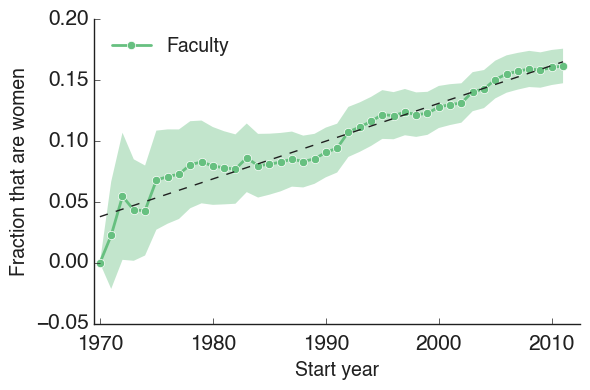

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

#http://www.nsf.gov/statistics/infbrief/nsf08308/

nsf_years = np.array([1985, 1987, 1989, 1991, 1993, 1995, 1997, 1999, 2001, 2003, 2006])
nsf_fracs = np.array([12.6, 13.1, 13.9, 15.2, 18.4, 17.2, 20.4, 22.2, 19.9, 17.7, 21.2]) / 100.

def mean_confidence(positives, total, confidence=0.95, iters=1000, z=1.96):
    upper = np.zeros_like(total, dtype=float)
    lower = np.zeros_like(upper)
    avg = np.zeros_like(lower)
    
    for i in xrange(len(positives)):
        pos = positives[i]
        tot = float(total[i])
        if tot == 0:
            continue
        p = pos / tot
        avg[i] = p
        pm = z*np.sqrt((1./tot)*p*(1-p))
        upper[i] = p + pm
        lower[i] = np.max(p - pm, 0.)
        
    return avg, upper, lower
        
    
avg, upper, lower = mean_confidence(start_years_hist_women, start_years_hist)    
avg, upper, lower = mean_confidence(cumulative_women, cumulative_all)    
ax.fill_between(year_range, lower, upper, color=FEMALE_COLOR, alpha=0.4, edgecolor="None")
ax.plot(year_range, avg, '-o', color=FEMALE_COLOR, linewidth=LINE_WIDTH, solid_capstyle="round", markeredgecolor='w',
        label='Faculty')

slope, intercept, r_value, p_value, std_err = sp.stats.linregress(year_range,avg)
print slope
ax.plot(year_range, intercept + year_range*slope, '--', color=ALMOST_BLACK)

#ax.set_ylim(0, .2)
x_pad = 0.5
ax.set_xlim(1970-x_pad, 2012+x_pad)
ax.set_xticks([1970, 1980, 1990, 2000, 2010])

# NSF
#ax.plot(nsf_years, nsf_fracs, '-s', color=DARK_COLOR, linewidth=LINE_WIDTH, label='Faculty (NSF)', markeredgecolor='w')
# NCES
#ax.plot(nces_years, np.cumsum(nces_women)/np.cumsum(nces_total), '-o', color=ALMOST_BLACK, linewidth=LINE_WIDTH, label='PhDs (NCES)', markeredgecolor='w')

ax.set_xlabel('Start year', fontsize=LABEL_SIZE)
ax.set_ylabel('Fraction that are women', fontsize=LABEL_SIZE)
ax.tick_params(axis='both', which='major', labelsize=TICK_SIZE)
hide_right_top_axis(ax)

'''
f1 = Line2D(range(1), range(1), color=FEMALE_COLOR, marker='o',markersize=15, linestyle='None', markeredgecolor='w')
f2 = Line2D(range(1), range(1), color=DARK_COLOR, marker='o',markersize=15, linestyle='None', markeredgecolor='w')
f3 = Line2D(range(1), range(1), color=ALMOST_BLACK, marker='o',markersize=15, linestyle='None', markeredgecolor='w')

f1 = Line2D(range(1), range(1), color=FEMALE_COLOR, linestyle='-', linewidth=LINE_WIDTH, markeredgecolor=FEMALE_COLOR)
f2 = Line2D(range(1), range(1), color=DARK_COLOR, linestyle='-', linewidth=LINE_WIDTH)
f3 = Line2D(range(1), range(1), color=ALMOST_BLACK, linestyle=':', linewidth=LINE_WIDTH)
plt.legend((f1,f2,f3),('Faculty','Faculty (NSF)', 'PhDs (NCES)'), numpoints=1, loc='upper left', frameon=False, fontsize=LABEL_SIZE)
'''
plt.legend(numpoints=1, loc='upper left', frameon=False, fontsize=LABEL_SIZE)

plt.show()

In [38]:
slope, intercept, r_value, p_value, std_err = sp.stats.linregress(year_range,avg)
print slope, intercept

0.00310383729725 -6.07655583652


In [39]:
year = 1970
while year < 2200:
    print year, year*slope + intercept
    year += 1

1970 0.0380036390572
1971 0.0411074763545
1972 0.0442113136517
1973 0.047315150949
1974 0.0504189882462
1975 0.0535228255435
1976 0.0566266628407
1977 0.059730500138
1978 0.0628343374352
1979 0.0659381747324
1980 0.0690420120297
1981 0.0721458493269
1982 0.0752496866242
1983 0.0783535239214
1984 0.0814573612187
1985 0.0845611985159
1986 0.0876650358132
1987 0.0907688731104
1988 0.0938727104077
1989 0.0969765477049
1990 0.100080385002
1991 0.103184222299
1992 0.106288059597
1993 0.109391896894
1994 0.112495734191
1995 0.115599571488
1996 0.118703408786
1997 0.121807246083
1998 0.12491108338
1999 0.128014920677
2000 0.131118757975
2001 0.134222595272
2002 0.137326432569
2003 0.140430269866
2004 0.143534107164
2005 0.146637944461
2006 0.149741781758
2007 0.152845619055
2008 0.155949456353
2009 0.15905329365
2010 0.162157130947
2011 0.165260968244
2012 0.168364805542
2013 0.171468642839
2014 0.174572480136
2015 0.177676317433
2016 0.180780154731
2017 0.183883992028
2018 0.186987829325
2019

In [40]:
def myOLS(X, Y):
    x = np.array(X)
    y = np.array(Y)
    n = len(x)
    dof = n - 2
    
    Sx = np.sum(x)
    Sy = np.sum(y)
    Sxx = np.sum(x**2)
    Sxy = np.dot(x,y)
    Syy = np.sum(y**2)
    
    beta = (n*Sxy - Sx*Sy) / (n*Sxx - Sx**2)
    alpha = (Sy/n) - (beta/n)*Sx
    s2e = (1./(n*(n-2)))*(n*Syy - Sy**2 - (beta**2)*(n*Sxx - Sx**2))
    s2b = (n*s2e)/(n*Sxx - Sx**2)
    s2a = (s2b/n)*Sxx
    
    t = sp.stats.t.ppf(1-0.025, df=dof)
    apm = t*np.sqrt(s2a)
    bpm = t*np.sqrt(s2b)
    
    return beta, alpha, bpm, apm
    
x = [1.47,1.50,1.52,1.55,1.57,1.60,1.63,1.65,1.68,1.70,1.73,1.75,1.78,1.80,1.83]
y = [52.21,53.12,54.48,55.84,57.20,58.57,59.93,61.29,63.11,64.47,66.28,68.10,69.92,72.19,74.46]

myOLS(x,y)

(61.272186542107434,
 -39.061955918838663,
 3.8366478501867989,
 6.3471654181999693)

0.00437651744664


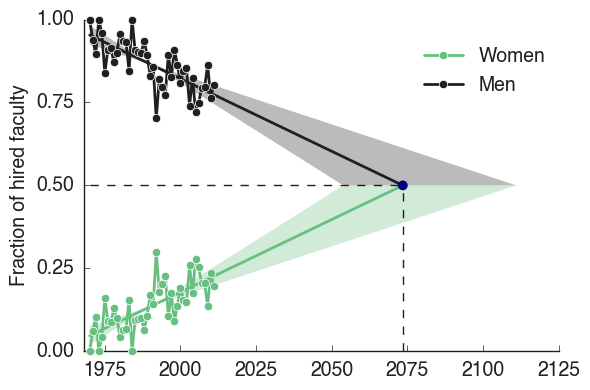

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

xmin, xmax = 1970,2125

ax.plot(year_range, start_years_hist_women/start_years_hist, '-o', color=FEMALE_COLOR, linewidth=LINE_WIDTH, solid_capstyle="round", markeredgecolor='w',
        label='Women', clip_on=False, zorder=9)
ax.plot(year_range, 1.-(start_years_hist_women/start_years_hist), '-o', color=ALMOST_BLACK, linewidth=LINE_WIDTH, solid_capstyle="round", markeredgecolor='w',
        label='Men', clip_on=False, zorder=9)


m1, b1, m1pm, b1pm = myOLS(year_range, start_years_hist_women/start_years_hist)
m2, b2, m2pm, b2pm = myOLS(year_range, 1.-(start_years_hist_women/start_years_hist))
x_parity = (b2-b1)/(m1-m2)
y_parity = intercept + x_parity*slope
year_rounded = np.round(x_parity)

plot_x = np.array([xmin, x_parity])
print m1
ax.plot(plot_x, b1 + plot_x*m1, '-', color=FEMALE_COLOR, linewidth=LINE_WIDTH, solid_capstyle="round")
ax.plot(plot_x, b2 + plot_x*m2, '-', color=ALMOST_BLACK, linewidth=LINE_WIDTH, solid_capstyle="round")
ax.plot([xmin, x_parity], [0.5, 0.5], '--', color=ALMOST_BLACK)

plot_x = np.linspace(xmin, xmax, 100)
lower = (b2+b2pm) + plot_x*(m2-m2pm)
upper = (b2-b2pm) + plot_x*(m2+m2pm)
lower[np.where(lower < 0.5)] = 0.5
upper[np.where(upper < 0.5)] = 0.5
ax.fill_between(plot_x, lower, upper, color=ALMOST_BLACK, alpha=0.3, edgecolor='None')

lower = (b1+b1pm) + plot_x*(m1-m1pm)
upper = (b1-b1pm) + plot_x*(m1+m1pm)
lower[np.where(lower > 0.5)] = 0.5
upper[np.where(upper > 0.5)] = 0.5
ax.fill_between(plot_x, lower, upper, color=FEMALE_COLOR, alpha=0.3, edgecolor='None')


#ax.plot([xmin, 2008], [0.5, 0.5], '--', color=ALMOST_BLACK)
#ax.plot([2025, x_parity], [0.5, 0.5], '--', color=ALMOST_BLACK)
#ax.text(2010, 0.5, '(parity)', fontsize=LABEL_SIZE, verticalalignment='center')

ax.plot([x_parity, x_parity], [0, 0.5], '--', color=ALMOST_BLACK)
#ax.plot([2115, 2115], [0, y_parity], '--', color=ALMOST_BLACK)
ax.scatter([x_parity], [0.5], s=50, c=ALMOST_BLACK, edgecolor='None', zorder=10)

ax.set_xticks([1975, 2000, 2025, 2050, 2075, 2100, 2125])
ax.set_yticks([0., .25, .5, .75, 1.])
#ax.set_yticklabels([0, 25, 50, 75, 100])
ax.set_xlim(xmin-2,xmax)
ax.set_ylim(0, 1)

ax.set_ylabel('Fraction of hired faculty', fontsize=LABEL_SIZE)
hide_right_top_axis(ax)
axbox = ax.get_position() #loc = 
plt.legend(numpoints=1, frameon=False, fontsize=LABEL_SIZE, loc=(.7, .75))
ax.tick_params(axis='both', which='major', labelsize=LABEL_SIZE, pad=7)

plt.savefig(os.path.join(figures_dir, 'parity.pdf'))
plt.show()

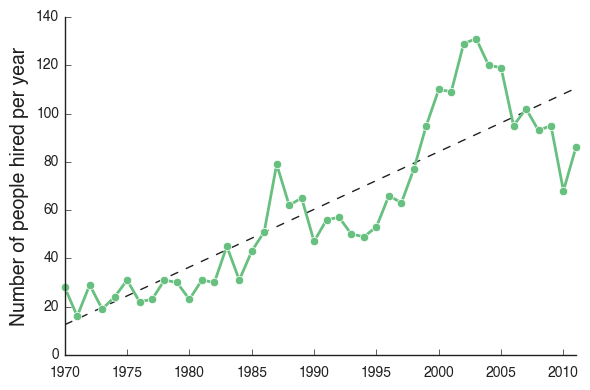

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

#http://www.nsf.gov/statistics/infbrief/nsf08308/

nsf_years = np.array([1985, 1987, 1989, 1991, 1993, 1995, 1997, 1999, 2001, 2003, 2006])
nsf_fracs = np.array([12.6, 13.1, 13.9, 15.2, 18.4, 17.2, 20.4, 22.2, 19.9, 17.7, 21.2]) / 100.

def mean_confidence(positives, total, confidence=0.95, iters=1000, z=1.96):
    upper = np.zeros_like(total, dtype=float)
    lower = np.zeros_like(upper)
    avg = np.zeros_like(lower)
    
    for i in xrange(len(positives)):
        pos = positives[i]
        tot = float(total[i])
        if tot == 0:
            continue
        p = pos / tot
        avg[i] = p
        pm = z*np.sqrt((1./tot)*p*(1-p))
        upper[i] = p + pm
        lower[i] = np.max(p - pm, 0.)
        
    return avg, upper, lower

slope, intercept, r_value, p_value, std_err = sp.stats.linregress(year_range,start_years_hist)
ax.plot(year_range, intercept + year_range*slope, '--', color=ALMOST_BLACK)
            
ax.plot(year_range, start_years_hist, '-o', color=FEMALE_COLOR, linewidth=LINE_WIDTH, solid_capstyle="round", markeredgecolor='w',
        label='Faculty', clip_on=False)
ax.set_xlim(1970,2011)
ax.set_ylabel('Number of people hired per year', fontsize=LABEL_SIZE)
hide_right_top_axis(ax)

plt.show()

In [43]:
for i in xrange(len(year_range)):
    print year_range[i], '%.1f%%' % (100*start_years_hist_women[i]/start_years_hist[i])

1970 0.0%
1971 6.2%
1972 10.3%
1973 0.0%
1974 4.2%
1975 16.1%
1976 9.1%
1977 8.7%
1978 12.9%
1979 10.0%
1980 4.3%
1981 6.5%
1982 6.7%
1983 15.6%
1984 0.0%
1985 9.3%
1986 9.8%
1987 10.1%
1988 6.5%
1989 10.8%
1990 17.0%
1991 14.3%
1992 29.8%
1993 18.0%
1994 20.4%
1995 22.6%
1996 10.6%
1997 17.5%
1998 9.1%
1999 13.7%
2000 19.1%
2001 15.6%
2002 14.7%
2003 26.0%
2004 17.5%
2005 27.7%
2006 25.3%
2007 20.6%
2008 20.4%
2009 13.7%
2010 23.5%
2011 19.8%


In [44]:
for i in xrange(len(year_range)):
    print year_range[i], ':', '%d of %d' % (start_years_hist_women[i], start_years_hist[i])

1970 : 0 of 28
1971 : 1 of 16
1972 : 3 of 29
1973 : 0 of 19
1974 : 1 of 24
1975 : 5 of 31
1976 : 2 of 22
1977 : 2 of 23
1978 : 4 of 31
1979 : 3 of 30
1980 : 1 of 23
1981 : 2 of 31
1982 : 2 of 30
1983 : 7 of 45
1984 : 0 of 31
1985 : 4 of 43
1986 : 5 of 51
1987 : 8 of 79
1988 : 4 of 62
1989 : 7 of 65
1990 : 8 of 47
1991 : 8 of 56
1992 : 17 of 57
1993 : 9 of 50
1994 : 10 of 49
1995 : 12 of 53
1996 : 7 of 66
1997 : 11 of 63
1998 : 7 of 77
1999 : 13 of 95
2000 : 21 of 110
2001 : 17 of 109
2002 : 19 of 129
2003 : 34 of 131
2004 : 21 of 120
2005 : 33 of 119
2006 : 24 of 95
2007 : 21 of 102
2008 : 19 of 93
2009 : 13 of 95
2010 : 16 of 68
2011 : 17 of 86


In [45]:
count = 0

temp = np.zeros(10, dtype=float)

for person in all_faculty:
    if person.is_female and person.first_asst_job_year == 1992:
        plt.figure()
        count += 1
        plot(person.topic_dist)
        temp += person.topic_dist
        plt.ylim(0,1)
        plt.title(person.facultyName)

NameError: name 'plot' is not defined

In [46]:
plot(temp)

NameError: name 'plot' is not defined

In [47]:
topic_descriptions

['robots',
 'security',
 'theory',
 'vision',
 'arch',
 'distributed',
 'data',
 'sensor nets',
 'software',
 'ml']

In [48]:
'''
Bonnie John	   CMU	Studies HCI
Maria Veloso  	   CMU 	Robotics and AI
Elizabeth Bradley  MIT	Everything
Adele E. Howe Amherst	AI
I-Ling Yen Houston	HPC, distributed computing
Susan V. Vrbsky UIUC	Cloud computing
Maria Petrie FAU	Systems
Gita Alaghband Boulder	Parallel processing
Lori L. Pollock Pitt	Parallel, systems, architecture
Margo Seltzer Berkeley	Operating systems
Meera Sitharam Madison	Theory
Donna S. Reese TxA&M	Systems
Zena M. Ariola Harvard Programming languages
A. Louise Perkins Davis	Numerical Methods
Tulay Adali NCState	Signal processing + ML
Deborah A. Trytten MSU	Education, broadening participation
Lenore Mullin Syracuse	HPC Physics
Rohini K. Srihari SUNY Buff	Text
Diane J. Cook UIUC	AI, ML, Robotics
Joanne M. Atlee Maryland Software engineering
Jennifer Welch MIT	Distributed computing
'''

pass

In [49]:
faculty_types = np.zeros((len(inst), 6), dtype=float)
inst_sorted_tuples = sorted([(inst[school]['pi'], school) for school in inst])
inst_sorted = [x[1] for x in inst_sorted_tuples]

for person in all_faculty:
    faculty_type = 0
    if person.is_female:
        faculty_type += 3
    if person.current == 'Assistant Professor':
        faculty_type += 0
    elif person.current == 'Associate Professor':
        faculty_type += 1
    elif person.current == 'Full Professor':
        faculty_type += 2

    school_index = inst_sorted.index(person.place)
    faculty_types[school_index][faculty_type] += 1
    
hatches = [None, '//', 'x', None, '//', 'x']
alphas = [0.5, 0.75, 1, 0.5, 0.75, 1]
colors = [DARK_COLOR, DARK_COLOR, DARK_COLOR, FEMALE_COLOR, FEMALE_COLOR, FEMALE_COLOR]

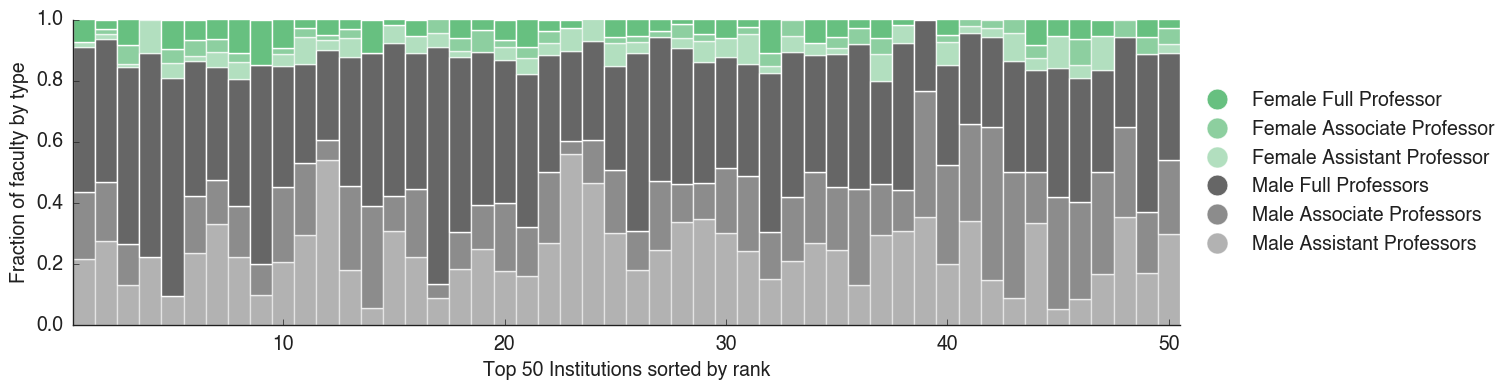

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(12,4))

from matplotlib.lines import Line2D

show_top = 50
width = 1

for i in xrange(show_top):
    
    types = faculty_types[i,:].copy()
    types /= types.sum()
    
    current_bottom = 0.
    for j in xrange(len(types)):
        if types[j] == 0:
            continue 
        #ax.bar(i, width=width, height=types[j], bottom=current_bottom, hatch=hatches[j], color=colors[j], edgecolor=ALMOST_BLACK)
        ax.bar(i, width=width, height=types[j], bottom=current_bottom, alpha=alphas[j], color=colors[j], edgecolor='w')
        current_bottom += types[j]

#ax.set_ylabel('Fraction of hired faculty', fontsize=LABEL_SIZE)
step = 10
ax.set_xticks(np.arange(1,100)*step - 0.5)
ax.set_xticklabels(np.arange(1,100)*step)

ax.set_ylim(0,1)
ax.set_xlim(0, show_top)
hide_right_top_axis(ax)
#axbox = ax.get_position() #loc = 
#plt.legend(numpoints=1, frameon=False, fontsize=LABEL_SIZE, loc=(.7, .75))
ax.set_xlabel('Top %d Institutions sorted by rank' % show_top, fontsize=LABEL_SIZE)
ax.set_ylabel('Fraction of faculty by type', fontsize=LABEL_SIZE)

ax.tick_params(axis='both', which='major', labelsize=LABEL_SIZE, pad=7)

markers = []
for i in xrange(len(types)):
    markers.append(Line2D(range(1), range(1), color=colors[i], alpha=alphas[i], marker='o',markersize=15, linestyle='None', markeredgecolor='w'))
labels = ['Male Assistant Professors', 'Male Associate Professors', 'Male Full Professors',
          'Female Assistant Professor', 'Female Associate Professor', 'Female Full Professor']

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
lgd = ax.legend(markers[::-1],labels[::-1], numpoints=1, frameon=False, fontsize=LABEL_SIZE, loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig(os.path.join(figures_dir, 'ratios%d.pdf' % show_top), bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

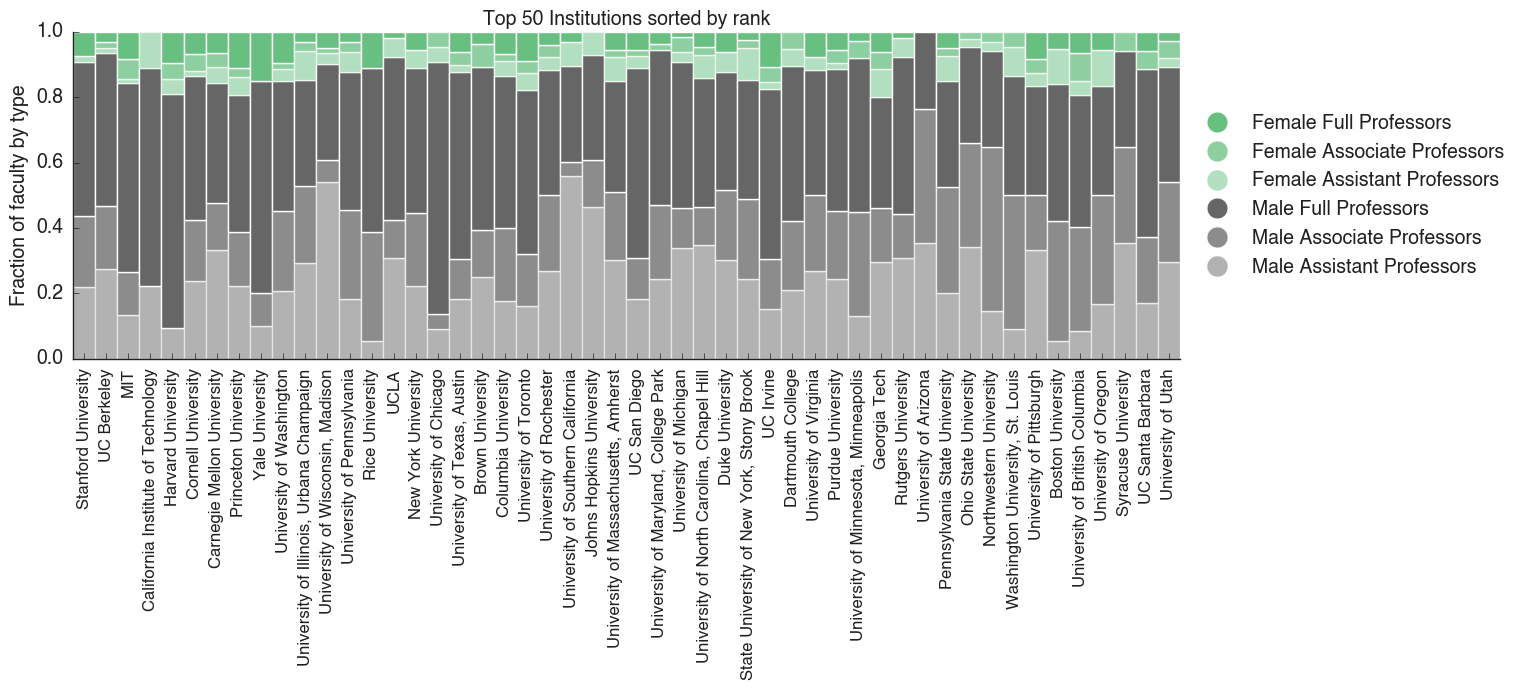

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(12,7))

show_top = 50
width = 1

for i in xrange(show_top):
    types = faculty_types[i,:].copy()
    types /= types.sum()
    
    current_bottom = 0.
    for j in xrange(len(types)):
        if types[j] == 0:
            continue 
        #ax.bar(i, width=width, height=types[j], bottom=current_bottom, hatch=hatches[j], color=colors[j], edgecolor=ALMOST_BLACK)
        ax.bar(i, width=width, height=types[j], bottom=current_bottom, alpha=alphas[j], color=colors[j], edgecolor='w')
        current_bottom += types[j]

#ax.set_ylabel('Fraction of hired faculty', fontsize=LABEL_SIZE)
step = 1
ax.set_xticks(np.arange(1,100)*step - 0.5)
ax.set_xticklabels(inst_sorted[:show_top], rotation='vertical')

ax.set_ylim(0,1)
ax.set_xlim(0, show_top)
hide_right_top_axis(ax)
ax.set_title('Top %d Institutions sorted by rank' % show_top, fontsize=LABEL_SIZE)
ax.set_ylabel('Fraction of faculty by type', fontsize=LABEL_SIZE)

ax.tick_params(axis='both', which='major', labelsize=LABEL_SIZE, pad=7)
ax.tick_params(axis='x', which='major', labelsize=LABEL_SIZE-2, pad=7)

markers = []
for i in xrange(len(types)):
    markers.append(Line2D(range(1), range(1), color=colors[i], alpha=alphas[i], marker='o',markersize=15, linestyle='None', markeredgecolor='w'))
labels = ['Male Assistant Professors', 'Male Associate Professors', 'Male Full Professors',
          'Female Assistant Professors', 'Female Associate Professors', 'Female Full Professors']

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
lgd = ax.legend(markers[::-1],labels[::-1], numpoints=1, frameon=False, fontsize=LABEL_SIZE, loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig(os.path.join(figures_dir, 'ratios%d.pdf' % show_top), bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

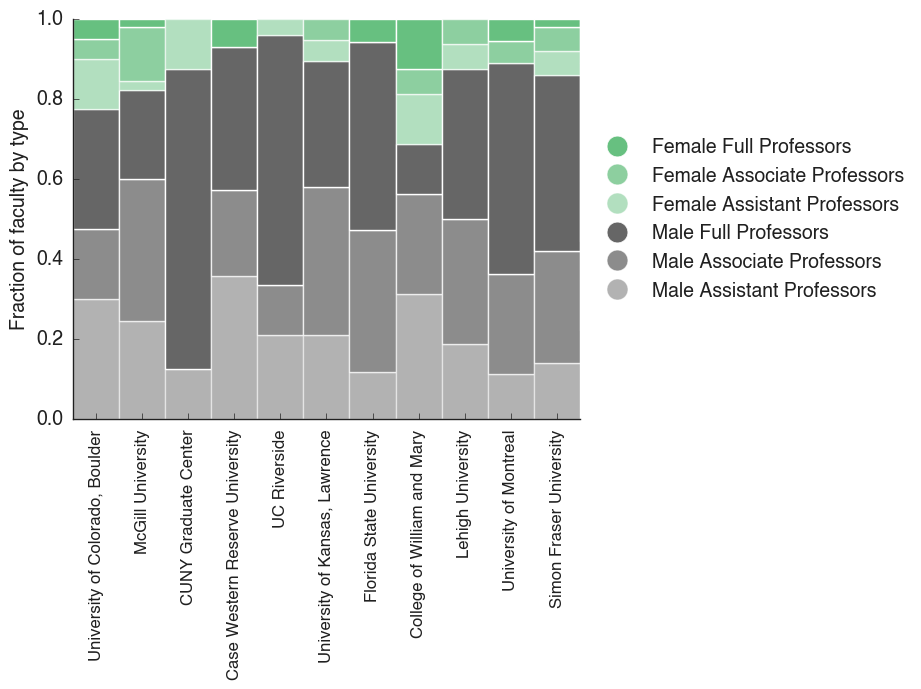

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(6,7))

show_top = 50
width = 1

beg = inst_sorted.index('University of Colorado, Boulder')
end = beg + 11
current = 0

for i in xrange(len(inst_sorted)):
    if i < beg:
        continue
    if i > end:
        break
    
    types = faculty_types[i,:].copy()
    types /= types.sum()
    
    current_bottom = 0.
    for j in xrange(len(types)):
        if types[j] == 0:
            continue 
        #ax.bar(i, width=width, height=types[j], bottom=current_bottom, hatch=hatches[j], color=colors[j], edgecolor=ALMOST_BLACK)
        ax.bar(current, width=width, height=types[j], bottom=current_bottom, alpha=alphas[j], color=colors[j], edgecolor='w')
        current_bottom += types[j]
    current += 1

#ax.set_ylabel('Fraction of hired faculty', fontsize=LABEL_SIZE)
step = 1
ax.set_xticks(np.arange(1,100)*step - 0.5)
ax.set_xticklabels(inst_sorted[beg:end+1], rotation='vertical')

ax.set_ylim(0,1)
ax.set_xlim(0, end-beg)
hide_right_top_axis(ax)
ax.set_ylabel('Fraction of faculty by type', fontsize=LABEL_SIZE)

ax.tick_params(axis='both', which='major', labelsize=LABEL_SIZE, pad=7)
ax.tick_params(axis='x', which='major', labelsize=LABEL_SIZE-2, pad=7)

markers = []
for i in xrange(len(types)):
    markers.append(Line2D(range(1), range(1), color=colors[i], alpha=alphas[i], marker='o',markersize=15, linestyle='None', markeredgecolor='w'))
labels = ['Male Assistant Professors', 'Male Associate Professors', 'Male Full Professors',
          'Female Assistant Professors', 'Female Associate Professors', 'Female Full Professors']

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
lgd = ax.legend(markers[::-1],labels[::-1], numpoints=1, frameon=False, fontsize=LABEL_SIZE, loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig(os.path.join(figures_dir, 'ratios_CU2.pdf'), bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

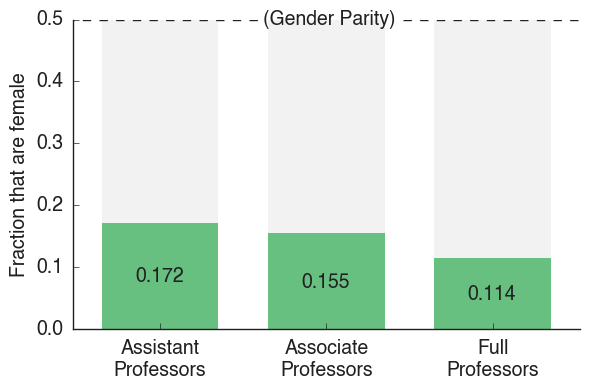

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

show_top = 207
female_offset = 3
width = 0.7
labels = ['Assistant\nProfessors', 'Associate\nProfessors', 'Full\nProfessors']

for f_type in xrange(3):
    ratio = np.sum(faculty_types[:show_top, f_type+female_offset]) / np.sum(faculty_types[:show_top, f_type+female_offset] +
                                                               faculty_types[:show_top, f_type])
    ax.bar(f_type, ratio, width=width, edgecolor='None', color=FEMALE_COLOR)
    ax.bar(f_type, 1-ratio, bottom=ratio, width=width, edgecolor='None', color='.95')
    ax.text(f_type+width/2-0.15, ratio/2-0.01, '%.3f' % ratio, fontsize=LABEL_SIZE)
    #ax.text(f_type+width/2-0.15, (1-ratio)/2.12 + ratio, '%.3f' % ratio, fontsize=LABEL_SIZE, color='k')

ax.set_xticks(np.arange(3) + width/2.)
ax.set_xticklabels(labels)

ax.plot((-5.2, 0.95), (0.5, 0.5), '--', color=ALMOST_BLACK)
ax.plot((1.81, 5), (0.5, 0.5), '--', color=ALMOST_BLACK)
ax.text(1-0.03, 0.491, '(Gender Parity)', fontsize=LABEL_SIZE)

ax.tick_params(axis='both', which='major', labelsize=LABEL_SIZE, pad=7)
ax.set_xlim(-width/4, 2+1.25*width)
hide_right_top_axis(ax)
ax.set_ylim(0, 0.5)

ax.set_ylabel('Fraction that are female', fontsize=LABEL_SIZE)
plt.savefig(os.path.join(figures_dir, 'fraction_by_type.pdf'))

plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

show_top = 207
female_offset = 3
width = 0.7
labels = ['Assistant\nProfessors', 'Associate\nProfessors', 'Full\nProfessors']

for f_type in xrange(3):
    perc = 100 * np.sum(faculty_types[:show_top, f_type+female_offset]) / np.sum(faculty_types[:show_top, f_type+female_offset] +
                                                               faculty_types[:show_top, f_type])
    ax.bar(f_type, perc, width=width, edgecolor='None', color=FEMALE_COLOR)
    ax.bar(f_type, 100-perc, bottom=perc, width=width, edgecolor='None', color='.95')
    ax.text(f_type+width/2-0.15, perc/2-1.5, '%.1f%%' % perc, fontsize=LABEL_SIZE)
    #ax.text(f_type+width/2-0.15, (1-ratio)/2.12 + ratio, '%.3f' % ratio, fontsize=LABEL_SIZE, color='k')

ax.set_xticks(np.arange(3) + width/2.)
ax.set_xticklabels(labels)

ax.plot((-5.2, 0.95), (50, 50), '--', color=ALMOST_BLACK)
ax.plot((1.75, 5), (50, 50), '--', color=ALMOST_BLACK)
ax.text(1-0.05, 49.1, '(Gender Parity)', fontsize=LABEL_SIZE)

ax.tick_params(axis='both', which='major', labelsize=LABEL_SIZE, pad=7)
ax.set_xlim(-width/4, 2+1.25*width)
hide_right_top_axis(ax)
ax.set_ylim(0, 50)

ax.set_ylabel('Percentage that are female', fontsize=LABEL_SIZE)
plt.savefig(os.path.join(figures_dir, 'perc_by_type.pdf'))

plt.show()

55